<a href="https://colab.research.google.com/github/adiu19/traffic-sign-recognition/blob/main/gtsrb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/assign2_dataset/

Mounted at /content/drive
/content/drive/My Drive/assign2_dataset


In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
base_path = "models/"

# Configurations

In [ ]:
batch_size = 32
momentum = 0.9
lr = 0.001 #changes at an experiment level
epochs = 200 #changes at an experiment level
log_interval = 10
nclasses = 43

In [ ]:
class_list = ['20_speed',
'30_speed',
'50_speed',
'60_speed',
'70_speed',
'80_speed',
'80_lifted',
'100_speed',
'120_speed',
'no_overtaking_general',
'no_overtaking_trucks',
'right_of_way_crossing',
'right_of_way_general',
'give_way',
'stop',
'no_way_general',
'no_way_trucks',
'no_way_one_way',
'attention_general',
'attention_left_turn',
'attention_right_turn',
'attention_curvy',
'attention_bumpers',
'attention_slippery',
'attention_bottleneck',
'attention_construction',
'attention_traffic_light',
'attention_pedestrian',
'attention_children',
'attention_bikes',
'attention_snowflake',
'attention_deer',
'lifted_general',
'turn_right',
'turn_left',
'turn_straight',
'turn_straight_right',
'turn_straight_left',
'turn_right_down',
'turn_left_down',
'turn_circle',
'lifted_no_overtaking_general',
'lifted_no_overtaking']

# Dataloader

In [ ]:
X_train_path="train/X.pt"
y_train_path="train/y.pt"

X_val_path="validation/X.pt"
y_val_path="validation/y.pt"

tensor_train_X = torch.load(X_train_path).squeeze(1)
tensor_train_Y = torch.load(y_train_path).squeeze(1)

tensor_val_X = torch.load(X_val_path).squeeze(1)
tensor_val_Y = torch.load(y_val_path).squeeze(1)

In [ ]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class MyDataset(Dataset):

    def __init__(self, tensor_X, tensor_Y):

        self.X = tensor_X
        self.y = tensor_Y
    
    def __len__(self):

        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(tensor_train_X, tensor_train_Y)
val_dataset = MyDataset(tensor_val_X, tensor_val_Y)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Visualizing Training Dataset

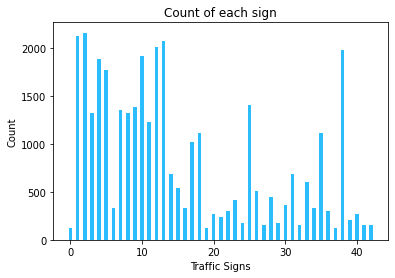

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


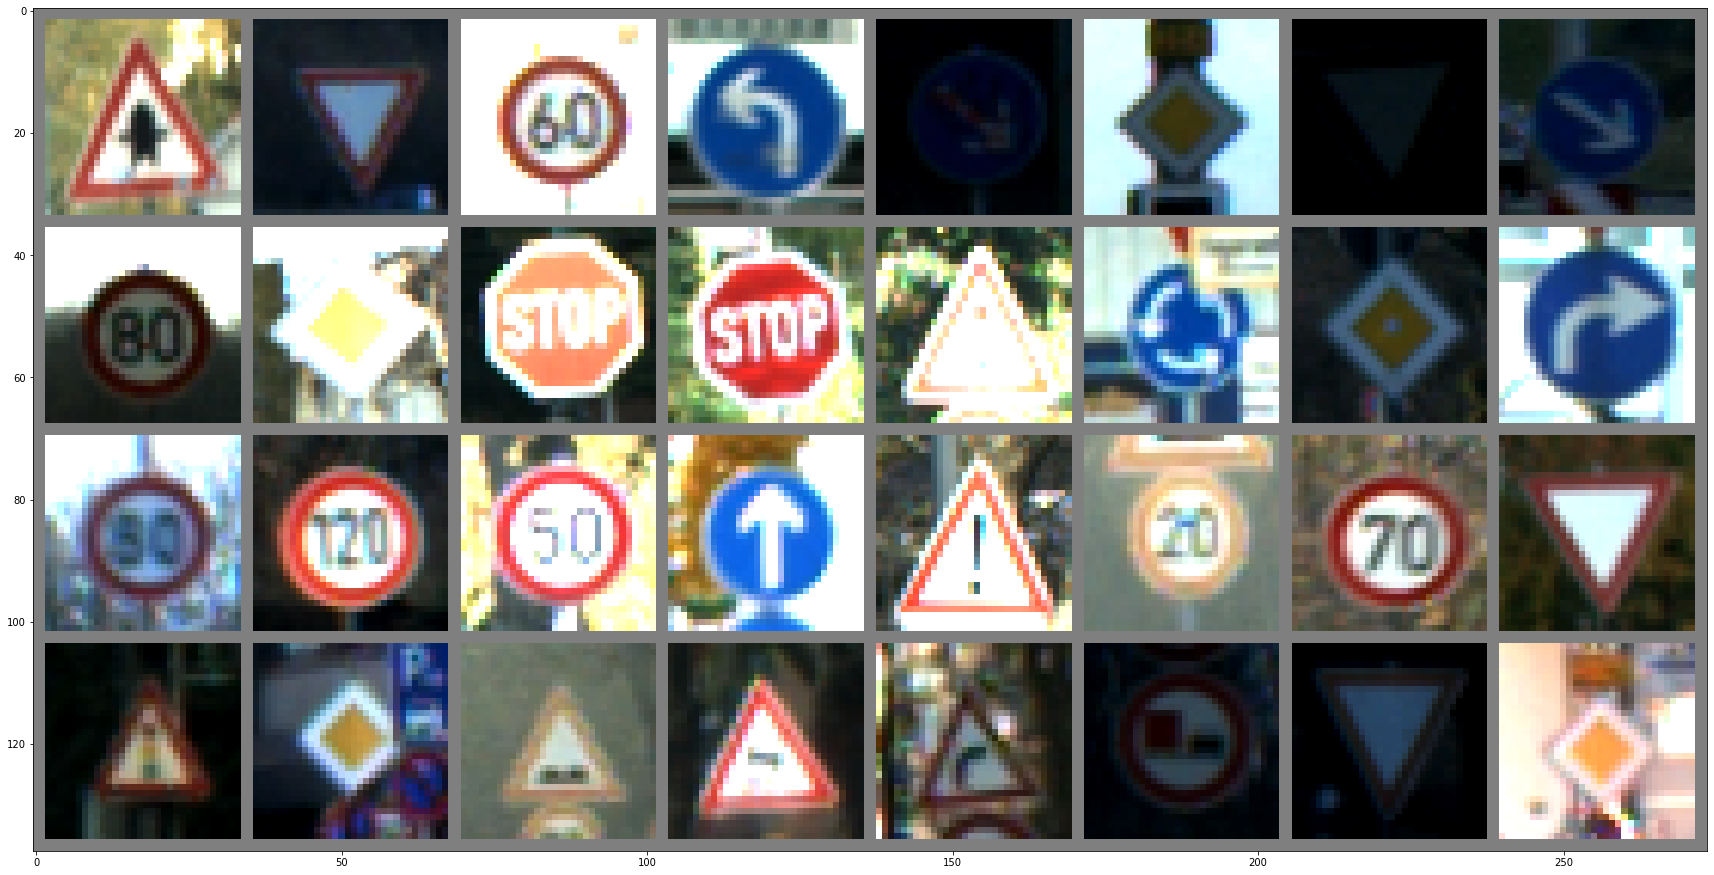

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms


fig, ax = plt.subplots()
ax.bar(range(nclasses), np.bincount(tensor_train_Y), 0.5, color='#2CBDFE')
ax.set_xlabel('Traffic Signs')
ax.set_ylabel('Count')
ax.set_title('Count of each sign')
plt.show()

loader_itr = iter(train_loader)
images, labels = loader_itr.next()

def plot_images(img):
    img = img / 2 + 0.5
    img_to_plot = img.numpy()
    plt.figure(figsize=[30, 20])
    plt.imshow(np.transpose(img_to_plot, (1, 2, 0)))
    plt.show()

plot_images(torchvision.utils.make_grid(images))

#Visualizing Validation Dataset

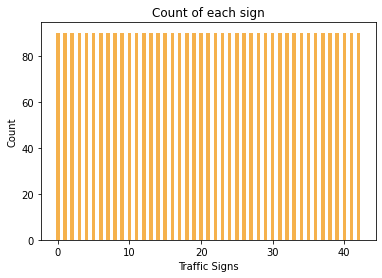

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()
ax.bar(range(nclasses), np.bincount(tensor_val_Y), 0.5, color='#F5B14C')
ax.set_xlabel('Traffic Signs')
ax.set_ylabel('Count')
ax.set_title('Count of each sign')
plt.show()

# [EXP-1] Base Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 200, kernel_size=3, padding=0)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.batchnorm1 = nn.BatchNorm2d(200)
        self.conv1_drop = nn.Dropout2d()

        self.conv2 = nn.Conv2d(200, 300, kernel_size=3, padding=0)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.batchnorm2 = nn.BatchNorm2d(300)
        self.conv2_drop = nn.Dropout2d()

        self.conv3 = nn.Conv2d(300, 350, kernel_size=3, padding=0)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        self.batchnorm3 = nn.BatchNorm2d(350)
        self.conv3_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(1400, 100)
        self.fc2 = nn.Linear(100, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        x = self.batchnorm1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.batchnorm2(x)
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = self.batchnorm3(x)

        x = x.view(-1, 1400)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

# Training

In [ ]:
model = Net()
model.to(device)
from torchsummary import summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 200, 30, 30]           5,600
         Dropout2d-2          [-1, 200, 30, 30]               0
       BatchNorm2d-3          [-1, 200, 15, 15]             400
            Conv2d-4          [-1, 300, 13, 13]         540,300
         Dropout2d-5          [-1, 300, 13, 13]               0
       BatchNorm2d-6            [-1, 300, 6, 6]             600
            Conv2d-7            [-1, 350, 4, 4]         945,350
         Dropout2d-8            [-1, 350, 4, 4]               0
       BatchNorm2d-9            [-1, 350, 2, 2]             700
           Linear-10                  [-1, 100]         140,100
           Linear-11                   [-1, 43]           4,343
Total params: 1,637,393
Trainable params: 1,637,393
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 **Training was done with both Adam and SGD, with different schedulers as well (Step, LROnPlateau)**


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR

model = Net()
model.to(device)
epochs = 200
lr = 0.001

#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=lr)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1, verbose=True)
#scheduler = ReduceLROnPlateau(optimizer, 'min',patience=5,factor=0.5,verbose=True)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        output = output.to(device)      

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    scheduler.step()

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return (100. * correct) / len(val_loader.dataset)

In [ ]:
epoch_tracker = []
val_acc_tracker = []

In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
    v_acc = validation()
    epoch_tracker.append(epoch)
    val_acc_tracker.append(v_acc.item())
    model_file = base_path + 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

# Plot Validation Accuracy Against Epoch

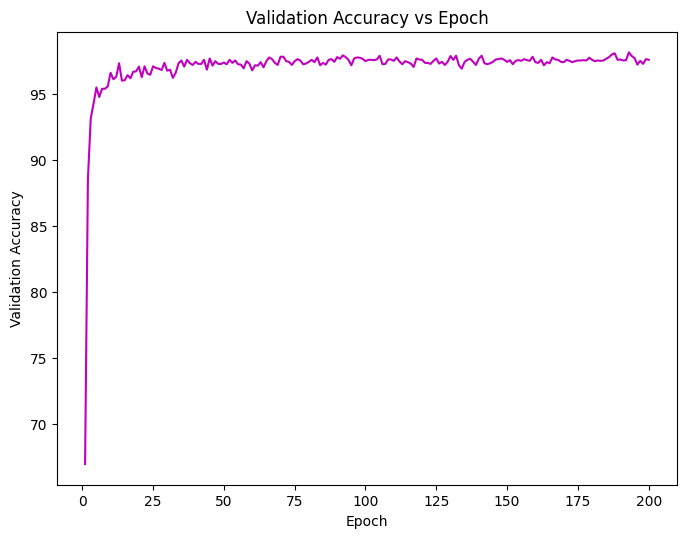

max val =  98.16537475585938  at  192


In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=100)

plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(epoch_tracker, val_acc_tracker, color ="m")
#plt.xticks(range(1,len(epoch_tracker)))
plt.show()

maxval = 0
idx = -1
for i in range(50, len(epoch_tracker)) :
  if val_acc_tracker[i] > maxval :
    maxval = val_acc_tracker[i]
    idx = i
print("max val = " , maxval , " at " , idx)

***Observed a faster convergence rate with the Adam optimizer compared to SGD.***

# Evaluate Base Model



In [ ]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle_192.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))

model = Net()
model.load_state_dict(torch.load(base_path + 'model_192' + '.pth'))
model.eval()

for i, data in enumerate(test_data):
    data = data.unsqueeze(0)

    output = model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

Written to csv file gtsrb_kaggle_192.csv


# Custom Dataset to Support Transformations

In [ ]:
from torch.utils.data import Dataset

class TDataset(Dataset):

    def __init__(self, tensor_X, tensor_Y, transform=None):

        self.X = tensor_X
        self.y = tensor_Y
        self.transform = transform
    
    def __len__(self):   
        return self.X.size(0)

    def __getitem__(self, idx):
      feature = self.X[idx]
      if self.transform is not None:
        feature = self.transform(feature)
      return feature, self.y[idx]

# Define Transformations

In [ ]:
import torchvision.transforms as transforms

#superset of transformations

t_rotate = transforms.Compose([
    transforms.RandomRotation(10) ,
])

t_hvflip = transforms.Compose([
    transforms.RandomHorizontalFlip(1),
    transforms.RandomVerticalFlip(1),
])

t_hflip = transforms.Compose([
    transforms.RandomHorizontalFlip(1),
])

t_vflip = transforms.Compose([
    transforms.RandomVerticalFlip(1),
])

t_shear = transforms.Compose([
    transforms.RandomAffine(degrees = 20,shear=2),
])

t_translate = transforms.Compose([
    transforms.RandomAffine(degrees = 25,translate=(0.1,0.1)),
])

t_jitter = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=0.3),
])

t_grayscale = transforms.Compose([
    transforms.RandomGrayscale(p=1),
])

t_randomaffine = transforms.Compose([
   transforms.RandomAffine(degrees=(-15, 15), translate=(0.1, 0.2))
])

# Apply Transformations and Augment Dataset

In [ ]:
from torch.utils.data import Dataset

augmented_train_loader = torch.utils.data.DataLoader(
   torch.utils.data.ConcatDataset([
   TDataset(tensor_train_X, tensor_train_Y, transform= t_randomaffine),
   TDataset(tensor_train_X, tensor_train_Y, transform= t_randomaffine),
   TDataset(tensor_train_X, tensor_train_Y, transform= t_randomaffine),
   TDataset(tensor_train_X, tensor_train_Y, transform= t_randomaffine),
   TDataset(tensor_train_X, tensor_train_Y, transform= t_randomaffine),
  ]), batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# [EXP-2] Train a tweaked version of the Base Model with Augmented Dataset

size of augmented dataset = ~180,000

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ModifiedBase(nn.Module):
    def __init__(self):
        super(ModifiedBase, self).__init__()

        self.conv1 = nn.Conv2d(3, 180, kernel_size=3, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(180)
        self.conv1_drop = nn.Dropout2d()

        self.conv2 = nn.Conv2d(180, 200, kernel_size=3, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(200)
        self.conv2_drop = nn.Dropout2d()

        self.conv3 = nn.Conv2d(200, 220, kernel_size=3, padding=0)
        self.batchnorm3 = nn.BatchNorm2d(220)
        self.conv3_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(3520, 100)
        self.fc2 = nn.Linear(100, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        x = self.batchnorm1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.batchnorm2(x)
        x = F.relu(self.conv3_drop(self.conv3(x)), 2)
        x = self.batchnorm3(x)

        x = x.view(-1, 3520)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [ ]:
mb = ModifiedBase()
mb.to(device)
from torchsummary import summary

summary(mb, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 180, 30, 30]           5,040
         Dropout2d-2          [-1, 180, 30, 30]               0
       BatchNorm2d-3          [-1, 180, 15, 15]             360
            Conv2d-4          [-1, 200, 13, 13]         324,200
         Dropout2d-5          [-1, 200, 13, 13]               0
       BatchNorm2d-6            [-1, 200, 6, 6]             400
            Conv2d-7            [-1, 220, 4, 4]         396,220
         Dropout2d-8            [-1, 220, 4, 4]               0
       BatchNorm2d-9            [-1, 220, 4, 4]             440
           Linear-10                  [-1, 100]         352,100
           Linear-11                   [-1, 43]           4,343
Total params: 1,083,103
Trainable params: 1,083,103
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
import numpy as np

mb_model = ModifiedBase()
mb_model.to(device)

epochs = 100
lr = 0.001

optimizer = optim.SGD(mb_model.parameters(), lr=lr, momentum=momentum)
#optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=lr)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1, verbose=True)

#scheduler = ReduceLROnPlateau(optimizer, 'min',patience=5,factor=0.5,verbose=True)

def train(epoch):
    mb_model.train()
    for batch_idx, (data, target) in enumerate(augmented_train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = mb_model(data)
        output = output.to(device)      

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(augmented_train_loader.dataset),
                100. * batch_idx / len(augmented_train_loader), loss.item()))
    #scheduler.step()

def validation():
    mb_model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = mb_model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    scheduler.step()
    return (100. * correct) / len(val_loader.dataset)

Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
epoch_tracker = []
val_acc_tracker = []

In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
    v_acc = validation()
    epoch_tracker.append(epoch)
    val_acc_tracker.append(v_acc.item())
    model_file = base_path + "final/" + 'model_' + str(epoch) + '.pth'
    torch.save(mb_model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

# [EXP-2 A] Using an Augmented Dataset with Vertical and Horizontal Flips

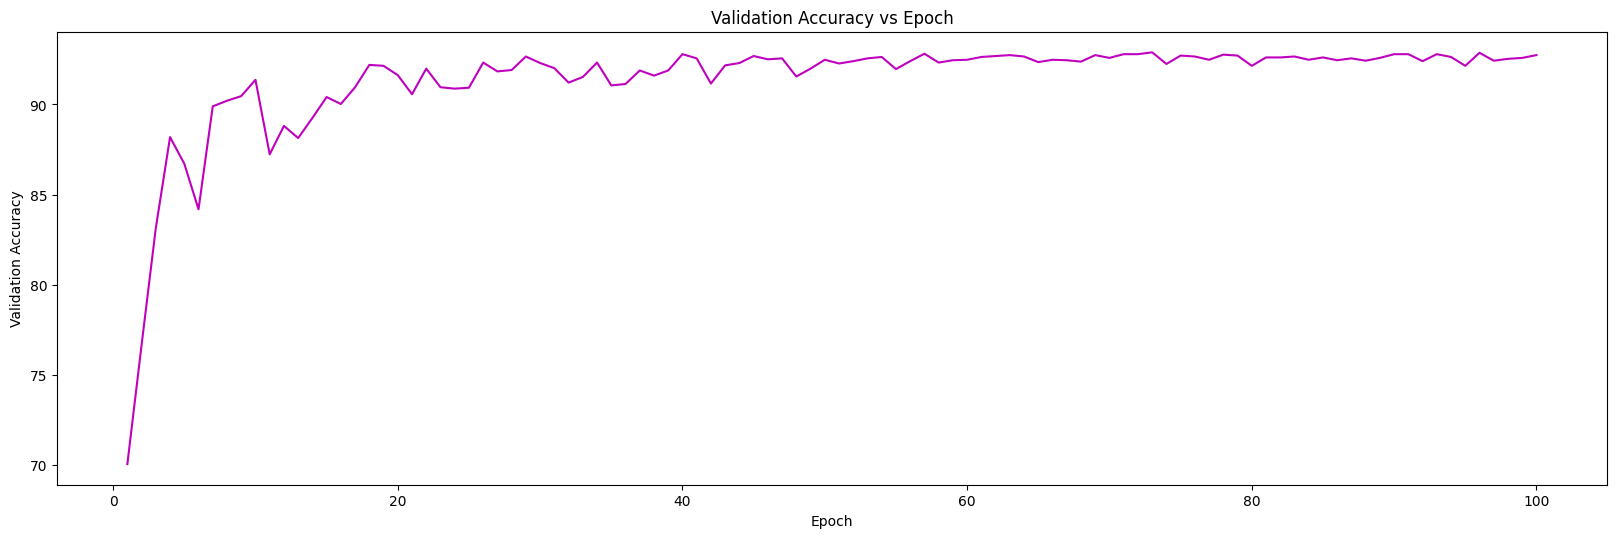

max val =  92.89405822753906  at  72


In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(20, 6), dpi=100)

plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(epoch_tracker, val_acc_tracker, color ="m")
plt.show()

maxval = 0
idx = -1
for i in range(1, len(epoch_tracker)) :
  if val_acc_tracker[i] > maxval :
    maxval = val_acc_tracker[i]
    idx = i
print("max val = " , maxval , " at " , idx)

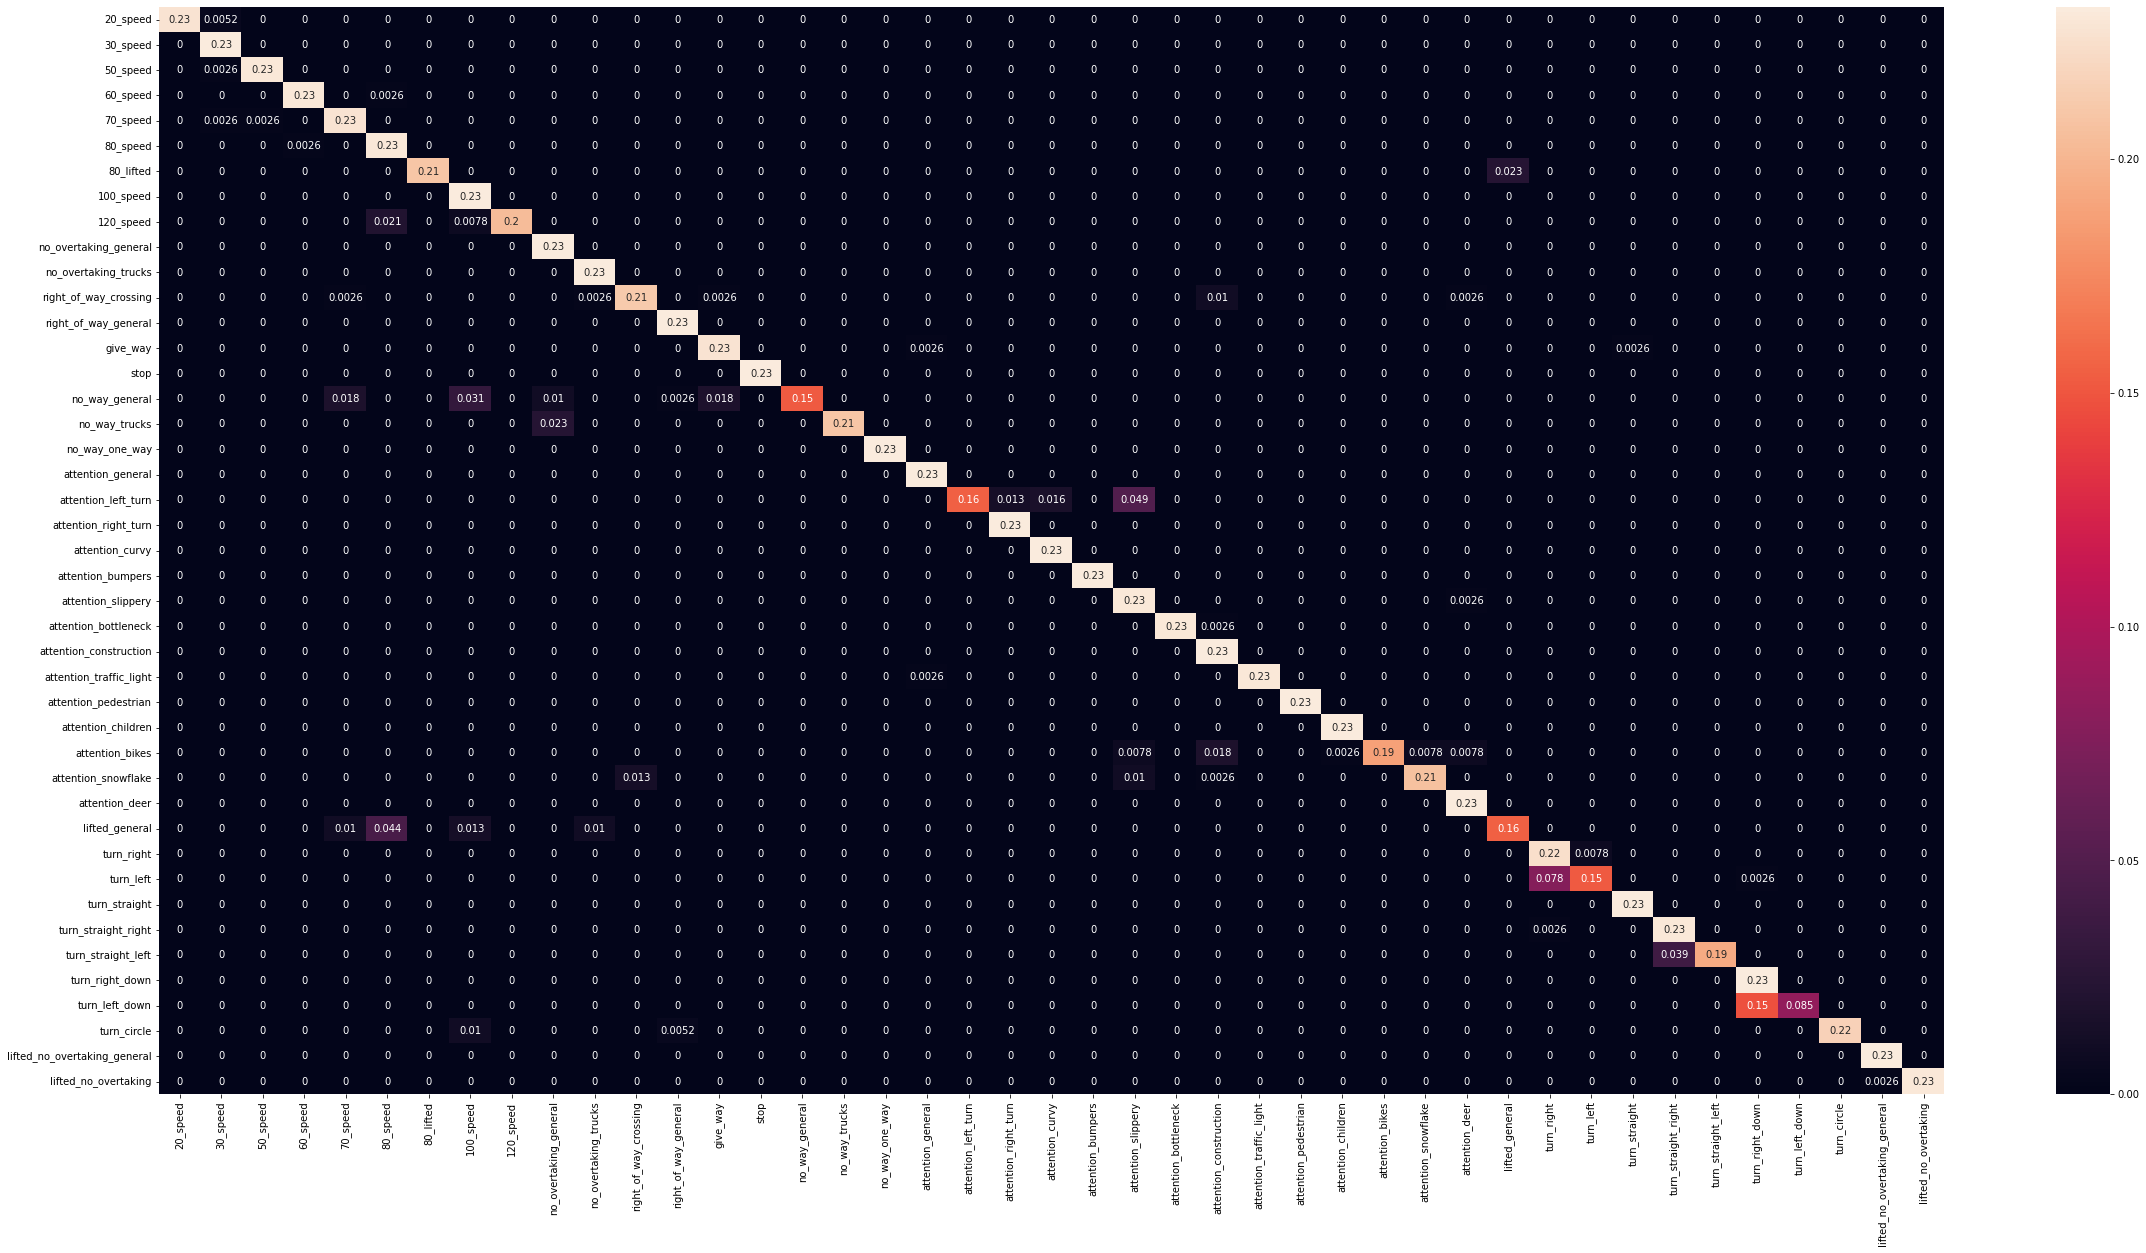

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plot_confusion_matrix(input_model, loader):
  input_model.eval()
  y_pred = []
  y_true = []

  for inputs, labels in loader:
    inputs = inputs.to(device)
    output = input_model(inputs)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)
          
    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_list],
                      columns = [i for i in class_list])
  plt.figure(figsize = (40,20))
  sn.heatmap(df_cm, annot=True)
  plt.savefig('output.png')

plot_confusion_matrix(model, val_loader)

**The matrix diagonal represents locations in the matrix where the prediction and the truth are the same, so this is where we want the heat map to be darker. Any values that are not on the diagonal are incorrect predictions because the prediction and the true label don't match.**

# [EXP-2 B] After Modifying Augmented Dataset (only Random Affine)

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


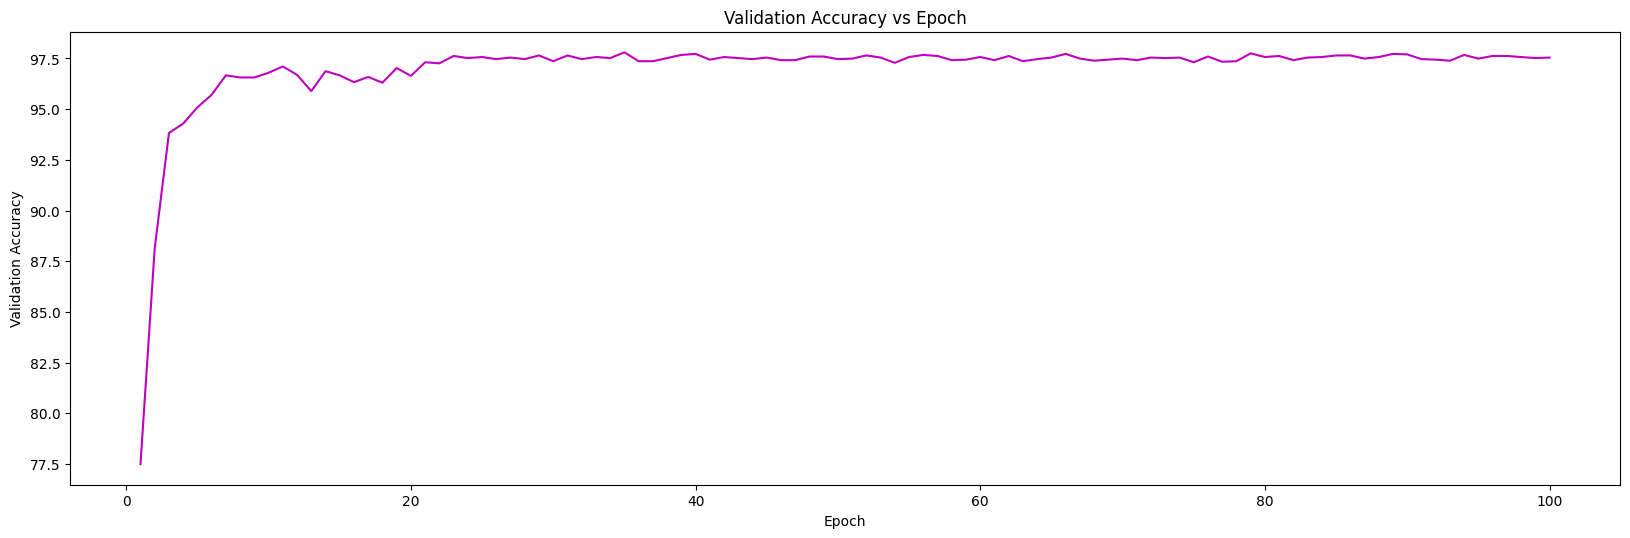

max val =  97.80361938476562  at  34


In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(20, 6), dpi=100)

plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(epoch_tracker, val_acc_tracker, color ="m")
plt.show()

maxval = 0
idx = -1
for i in range(1, len(epoch_tracker)) :
  if val_acc_tracker[i] > maxval :
    maxval = val_acc_tracker[i]
    idx = i
print("max val = " , maxval , " at " , idx)

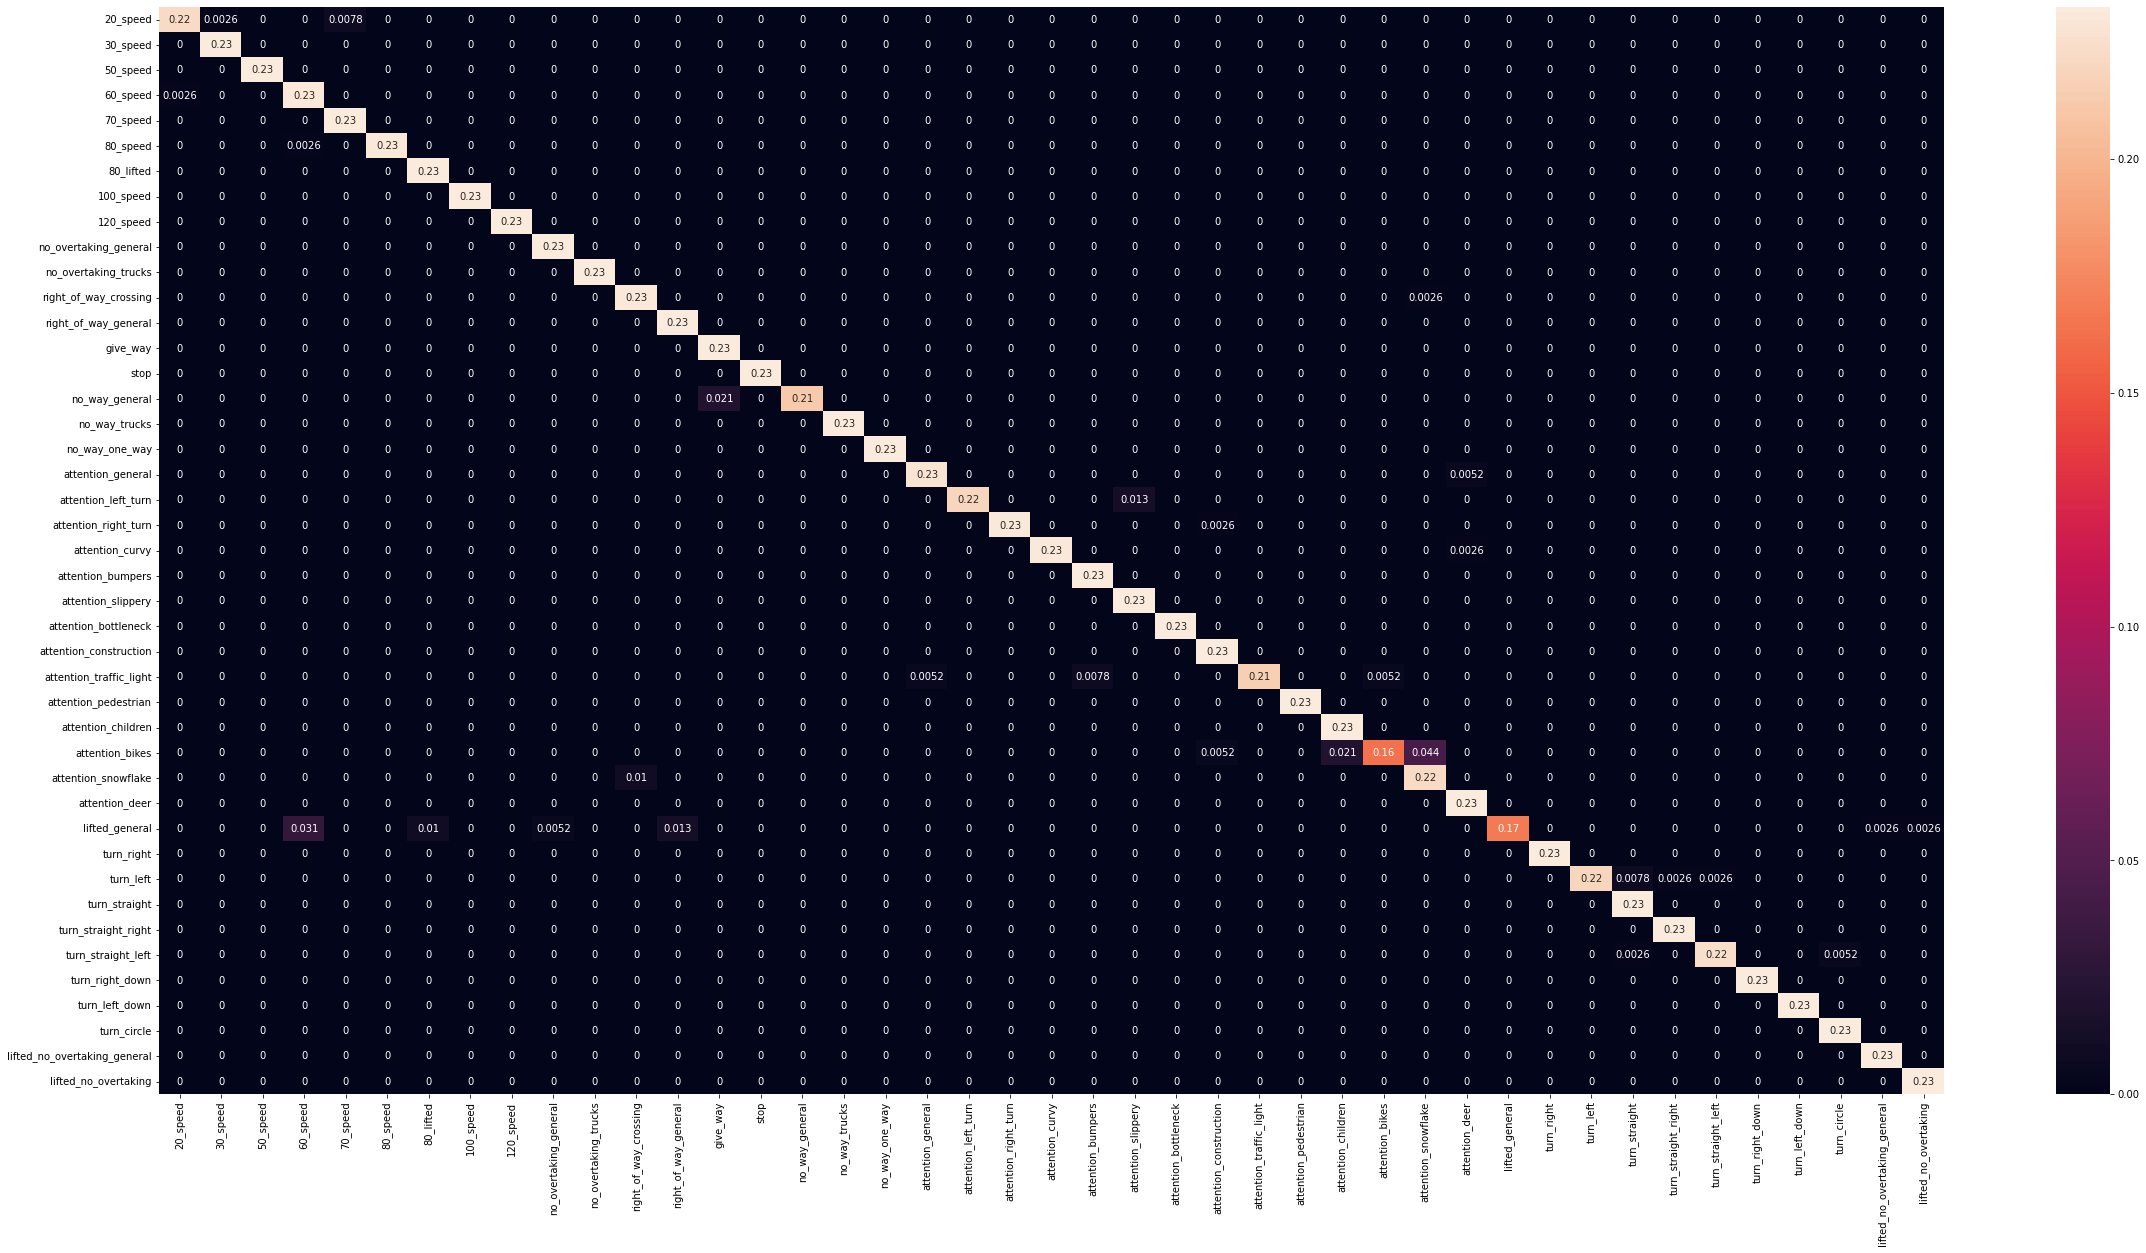

In [ ]:
plot_confusion_matrix(mb_model, val_loader)

**After removing the horizontal and vertical flips, the model performed way better and that can be seen easily using the confusion matrix (check out the entries for "attention left turn" and "attention right turn"). The model still doesn't correctly identifies the classes "attention children" and "attention bikes" and that is evident in the confusion matrix.** 

# [EXP-2 C] Using Random Affine Transformations and Reducing the number of Network Parameters.

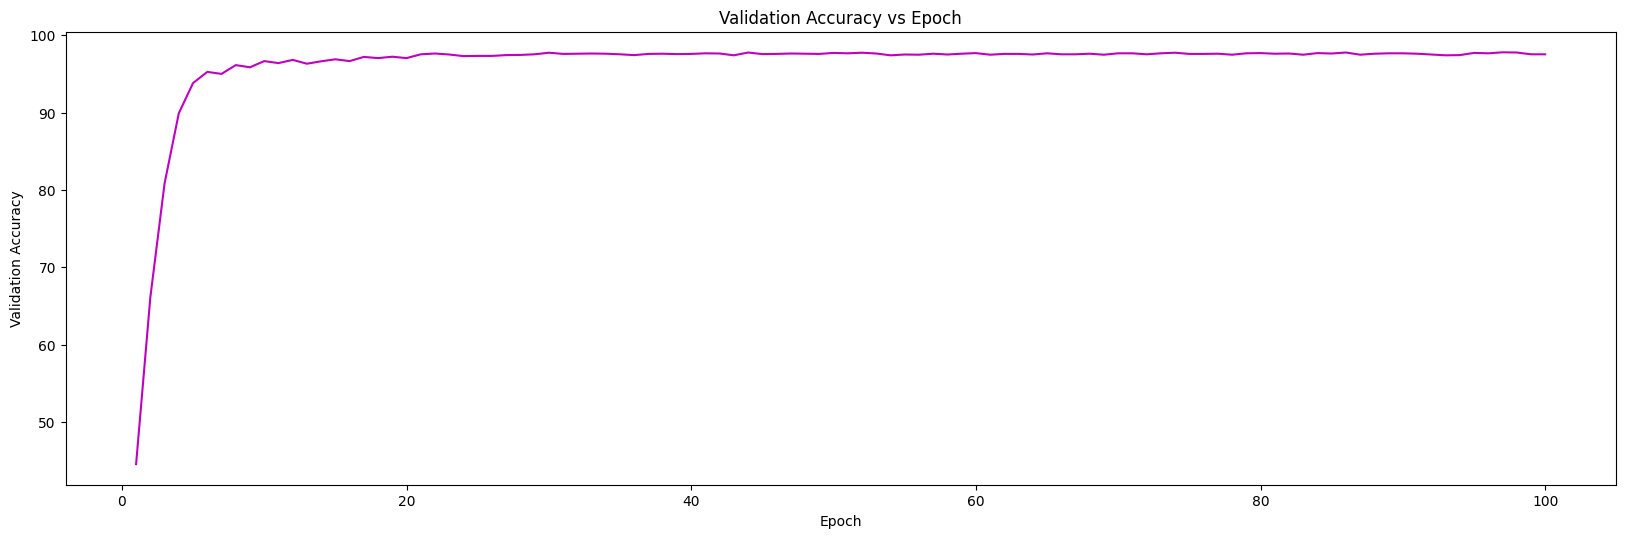

max val =  97.80361938476562  at  96


In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(20, 6), dpi=100)

plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(epoch_tracker, val_acc_tracker, color ="m")
plt.show()

maxval = 0
idx = -1
for i in range(1, len(epoch_tracker)) :
  if val_acc_tracker[i] > maxval :
    maxval = val_acc_tracker[i]
    idx = i
print("max val = " , maxval , " at " , idx)

In [ ]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle_aug.csv'

model_file = base_path + 'model_63' + '.pth'

print("loading = " , model_file)
output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))

model = Net()
model.load_state_dict(torch.load(model_file))
model.eval()

for i, data in enumerate(test_data):
    data = data.unsqueeze(0)
    data = data.to(device)
    output = s_model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

# [EXP-3] Spatial Transformations


Drawing inspirations from the DeepMind paper *Spatial Transformers Network* <a href="https://arxiv.org/pdf/1506.02025.pdf">[arxiv]</a>. 




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialNet(nn.Module):
    def __init__(self):
        super(SpatialNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 300, kernel_size=3, padding=0)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.batchnorm1 = nn.BatchNorm2d(300)
        self.conv1_drop = nn.Dropout2d()

        self.conv2 = nn.Conv2d(300, 400, kernel_size=3, padding=0)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.batchnorm2 = nn.BatchNorm2d(400)
        self.conv2_drop = nn.Dropout2d()

        self.conv3 = nn.Conv2d(400, 300, kernel_size=3, padding=0)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        self.batchnorm3 = nn.BatchNorm2d(300)
        self.conv3_drop = nn.Dropout2d()

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        self.fc1 = nn.Linear(1200, 90)
        self.fc2 = nn.Linear(90, nclasses)
    
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        x = self.stn(x)
        x = F.leaky_relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        x = self.batchnorm1(x)
        x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.batchnorm2(x)
        x = F.leaky_relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = self.batchnorm3(x)
        x = x.view(-1, 1200)
        x = F.leaky_relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [ ]:
spatial_model = SpatialNet()
spatial_model.to(device)
from torchsummary import summary

summary(spatial_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]           1,184
         MaxPool2d-2            [-1, 8, 13, 13]               0
              ReLU-3            [-1, 8, 13, 13]               0
            Conv2d-4             [-1, 10, 9, 9]           2,010
         MaxPool2d-5             [-1, 10, 4, 4]               0
              ReLU-6             [-1, 10, 4, 4]               0
            Linear-7                   [-1, 32]           5,152
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10          [-1, 300, 30, 30]           8,400
        Dropout2d-11          [-1, 300, 30, 30]               0
      BatchNorm2d-12          [-1, 300, 15, 15]             600
           Conv2d-13          [-1, 400, 13, 13]       1,080,400
        Dropout2d-14          [-1, 400,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import numpy as np

spatial_model = SpatialNet()
spatial_model.to(device)

epochs = 300
lr = 0.001

s_optimizer = optim.Adam(filter(lambda p: p.requires_grad,spatial_model.parameters()),lr=lr, weight_decay=0.005)
s_scheduler = ReduceLROnPlateau(s_optimizer, 'min',patience=5,factor=0.5,verbose=True)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def spatial_train(epoch, t_loader):
    spatial_model.train()
    for batch_idx, (data, target) in enumerate(t_loader):
        s_optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = spatial_model(data)
        output = output.to(device)      
        loss = F.nll_loss(output, target)
        loss.backward()
        s_optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} | rate = {} '.format(
                epoch, batch_idx * len(data), len(t_loader.dataset),
                100. * batch_idx / len(t_loader), loss.item(), get_lr(s_optimizer)))
    #s_scheduler.step()
    

def spatial_validation(v_loader):
    spatial_model.eval()
    validation_loss = 0
    correct = 0
    for data, target in v_loader:
        data = data.to(device)
        target = target.to(device)
        output = spatial_model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(v_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(v_loader.dataset),
        100. * correct / len(v_loader.dataset)))
    s_scheduler.step(np.around(validation_loss,2))
    return (100. * correct) / len(v_loader.dataset)

In [ ]:
#track validation accuracy after each epoch
spatial_epoch_tracker = []
spatial_val_acc_tracker = []

In [ ]:
out_path = base_path  + "spatial/"

for epoch in range(1, epochs + 1):
    spatial_train(epoch, train_loader)
    v_acc = spatial_validation(val_loader)
    spatial_epoch_tracker.append(epoch)
    spatial_val_acc_tracker.append(v_acc.item())
    model_file = out_path + 'model_' + str(epoch) + '.pth'
    torch.save(spatial_model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')


import numpy as np
stat_path = base_path + "stats/"
np.save(stat_path + "epochs.npy", spatial_epoch_tracker)
np.save(stat_path + "valacc.npy", spatial_val_acc_tracker)

# Validation Accuracy vs Epochs

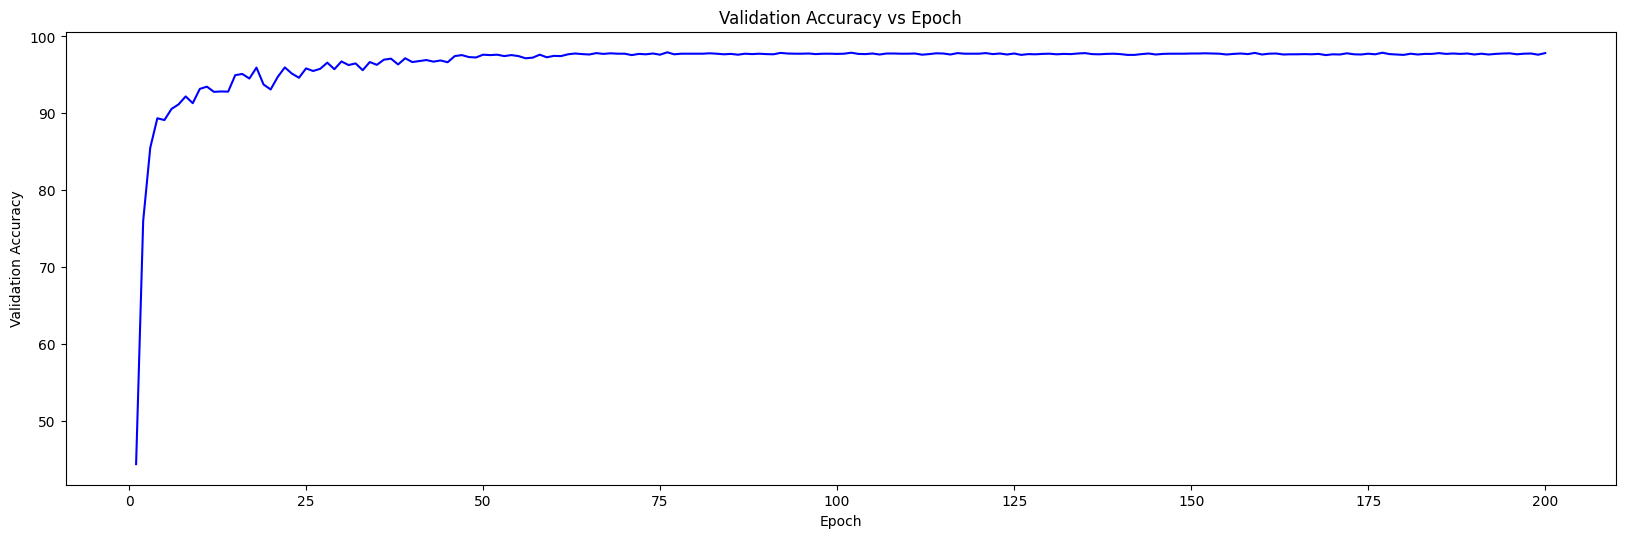

max val =  97.93281555175781  at  75


In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np

figure(figsize=(20, 6), dpi=100)

stat_path = base_path + "stats/"

spatial_epoch_tracker = np.load(stat_path + "epochs.npy")
spatial_val_acc_tracker = np.load(stat_path + "valacc.npy")


plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(spatial_epoch_tracker, spatial_val_acc_tracker, color ="b")
#plt.xticks(range(1,len(epoch_tracker)))
plt.show()

maxval = 0
idx = -1
for i in range(50, len(spatial_epoch_tracker)) :
  if spatial_val_acc_tracker[i] > maxval :
    maxval = spatial_val_acc_tracker[i]
    idx = i
print("max val = " , maxval , " at " , idx)

# Evaluate Spatial Model

In [ ]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle_spatial.csv'

model_path = base_path  + "spatial/"
model_to_load = model_path + 'model_200' + '.pth'

print("loading = " , model_to_load)
output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))

s_model = torch.load(model_to_load)
s_model.eval()

for i, data in enumerate(test_data):
    data = data.unsqueeze(0)
    data = data.to(device)
    output = s_model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

#[EXP-4] Spatial Model 2 (Simplified Version)

achieved an accuracy of 99.1 on the Kaggle leaderboard

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplifiedSpatialNet(nn.Module):
    def __init__(self):
        super(SimplifiedSpatialNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 120, kernel_size=5, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(120)
        
        self.conv_drop = nn.Dropout2d()

        self.conv2 = nn.Conv2d(120, 150, kernel_size=3, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(150)

        self.conv3 = nn.Conv2d(150, 200, kernel_size=3, padding=0)
        self.batchnorm3 = nn.BatchNorm2d(200)

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        self.fc1 = nn.Linear(800, 64)
        self.fc2 = nn.Linear(64, nclasses)
    
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        x = self.stn(x)
        #print(x.shape)
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
        x = self.batchnorm1(x)
        x = self.conv_drop(x)
        x = F.leaky_relu(F.max_pool2d(self.conv2(x), 2))
        x = self.batchnorm2(x)
        x = self.conv_drop(x)
        x = F.leaky_relu(F.max_pool2d(self.conv3(x), 2))
        x = self.batchnorm3(x)
        x = self.conv_drop(x)
        #print(x.shape)
        x = x.view(-1, 800)
        x = F.leaky_relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

# Train Spatial Model with Augmented Dataset

In [ ]:
ss_model = SimplifiedSpatialNet()
ss_model.to(device)
from torchsummary import summary

summary(ss_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]           1,184
         MaxPool2d-2            [-1, 8, 13, 13]               0
              ReLU-3            [-1, 8, 13, 13]               0
            Conv2d-4             [-1, 10, 9, 9]           2,010
         MaxPool2d-5             [-1, 10, 4, 4]               0
              ReLU-6             [-1, 10, 4, 4]               0
            Linear-7                   [-1, 32]           5,152
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10          [-1, 120, 28, 28]           9,120
      BatchNorm2d-11          [-1, 120, 14, 14]             240
        Dropout2d-12          [-1, 120, 14, 14]               0
           Conv2d-13          [-1, 150, 12, 12]         162,150
      BatchNorm2d-14            [-1, 15

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import numpy as np


epochs = 100
lr = 0.001

#ss_optimizer = optim.SGD(ss_model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
#ss_scheduler = ReduceLROnPlateau(ss_optimizer, 'min',patience=5,factor=0.1,verbose=True)

ss_optimizer = optim.Adam(filter(lambda p: p.requires_grad,ss_model.parameters()),lr=lr)
ss_scheduler = StepLR(ss_optimizer, step_size=20, gamma=0.1, verbose=True)

def get_lr(optimizer):
    for param_group in ss_optimizer.param_groups:
        return param_group['lr']

def ss_train(epoch, t_loader):
    ss_model.train()
    for batch_idx, (data, target) in enumerate(t_loader):
        ss_optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = ss_model(data)
        output = output.to(device)      
        loss = F.nll_loss(output, target)
        loss.backward()
        ss_optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} | rate = {} '.format(
                epoch, batch_idx * len(data), len(t_loader.dataset),
                100. * batch_idx / len(t_loader), loss.item(), get_lr(ss_optimizer)))    

def ss_validation(v_loader):
    ss_model.eval()
    validation_loss = 0
    correct = 0
    for data, target in v_loader:
        data = data.to(device)
        target = target.to(device)
        output = ss_model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(v_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(v_loader.dataset),
        100. * correct / len(v_loader.dataset)))
    ss_scheduler.step()
    #ss_scheduler.step(np.around(validation_loss,2))
    return (100. * correct) / len(v_loader.dataset)


Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
spatial_epoch_tracker = []
spatial_val_acc_tracker = []

In [ ]:
out_path = base_path  + "spatial/"
print("training for {} epochs".format(epochs))
for epoch in range(1, 101):
    ss_train(epoch, augmented_train_loader)
    v_acc = ss_validation(val_loader)
    spatial_epoch_tracker.append(epoch)
    spatial_val_acc_tracker.append(v_acc.item())
    model_file = out_path + 'model_' + str(epoch) + '.pth'
    torch.save(ss_model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

import numpy as np
stat_path = base_path + "stats/"
np.save(stat_path + "epochs.npy", spatial_epoch_tracker)
np.save(stat_path + "valacc.npy", spatial_val_acc_tracker)

In [ ]:
import numpy as np

stat_path = base_path + "stats/"

e = np.load(stat_path + "epochs.npy")
v = np.load(stat_path + "valacc.npy")

print(v)

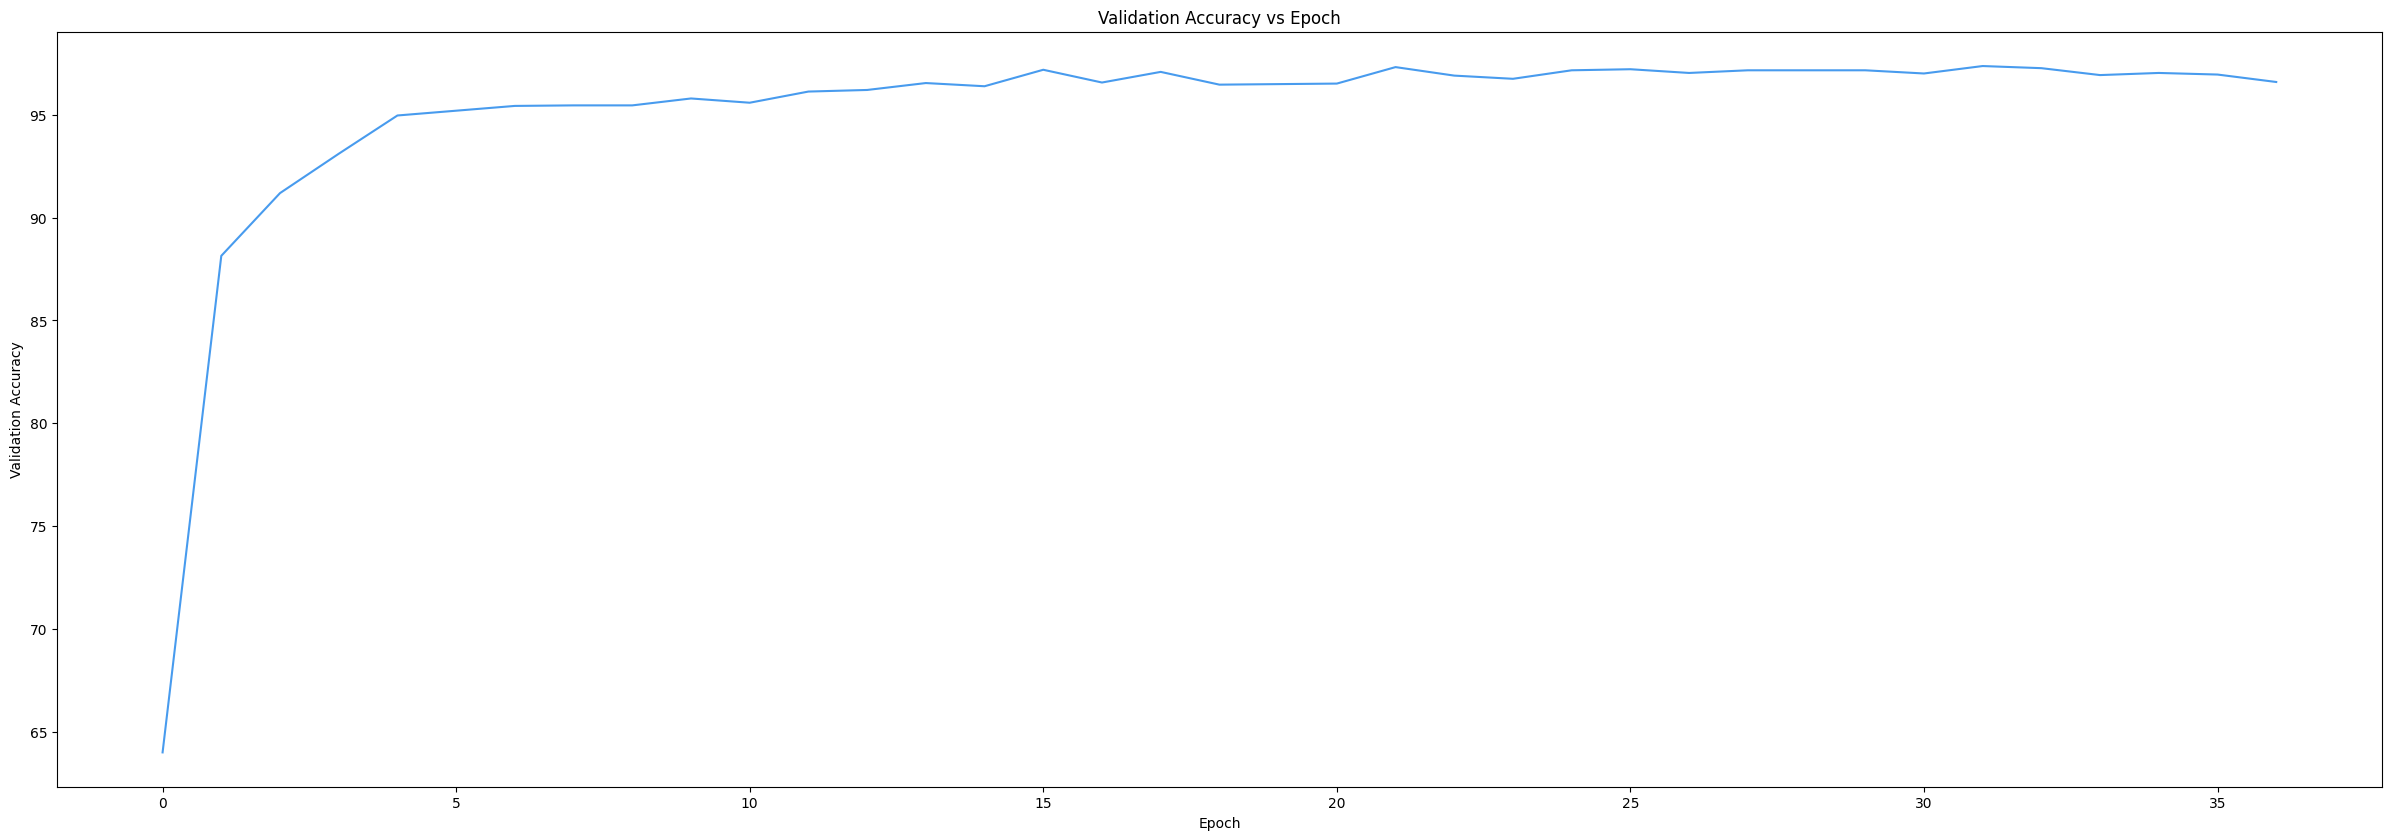

max val =  97.36434173583984  at  31


In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(30, 10), dpi=100)

plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(spatial_epoch_tracker, spatial_val_acc_tracker, color ="#489bee")
#plt.xticks(range(1,len(spatial_epoch_tracker)))
plt.show()

#print(spatial_val_acc_tracker)

maxval = 0
idx = -1
for i in range(len(spatial_epoch_tracker)) :
  if spatial_val_acc_tracker[i] > maxval :
    maxval = spatial_val_acc_tracker[i]
    idx = i
print("max val = " , maxval , " at " , idx)

In [ ]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle_spatial.csv'

model_path = base_path  + "spatial/"
model_to_load = model_path + 'model_14' + '.pth'

print("loading = " , model_to_load)
output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))

s_model = SpatialNet()
s_model.to(device)
s_model.load_state_dict(torch.load(model_to_load))

s_model.eval()

for i, data in enumerate(test_data):
    data = data.unsqueeze(0)
    data = data.to(device)
    output = s_model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)

loading =  models/spatial/model_14.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [ ]:
# !wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
# from colab_pdf import colab_pdf
# colab_pdf('cv_assignment_1_part2_au2056.ipynb')